# Package Buddy Thesis Evaluation
*By Matthew Avallone*

This notebook is used to evaluate Siamese Mask R-CNN within the scope of Package Buddy, an autonomous intelligent robotic delivery system. The few-shot object detector will aid in object detection and avoidance.

### Connect Google Drive to access code and data

In [0]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

In [0]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
#%load_ext line_profiler

%tensorflow_version 1.x
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.INFO)
sess_config = tf.ConfigProto()

import sys
import os

CWD = '/content/drive/My Drive/Thesis/siamese-mask-rcnn/'
if CWD not in sys.path:
    sys.path.append('/content/drive/My Drive/Thesis/siamese-mask-rcnn/')

# Install requirements
%run /content/drive/My\ Drive/Thesis/siamese-mask-rcnn//install_requirements.ipynb

COCO_DATA = '/content/drive/My Drive/Thesis/siamese-mask-rcnn/data/coco/'
MASK_RCNN_MODEL_PATH = '/content/drive/My Drive/Thesis/siamese-mask-rcnn/lib/Mask_RCNN/'

if MASK_RCNN_MODEL_PATH not in sys.path:
    sys.path.append(MASK_RCNN_MODEL_PATH)
    
from samples.coco import coco
from mrcnn import utils
from mrcnn import model as modellib
from mrcnn import visualize
    
from lib import utils as siamese_utils
from lib import model as siamese_model
from lib import config as siamese_config
   
import time
import datetime
import random
import numpy as np
import skimage.io
import imgaug
import pickle
import matplotlib.pyplot as plt
from collections import OrderedDict

# Root directory of the project
ROOT_DIR = '/content/drive/My Drive/Thesis/siamese-mask-rcnn/'

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

### Dataset

In [0]:
# all_classes = person, chair, couch, door, desk, elevator
# train_classes = person, chair, couch, desk
# novel_classes = door, elevator
all_classes = np.array(range(1,7))
train_classes = np.array([1,2,3,5]) 
novel_classes = np.array([4,6])

In [4]:
# Load COCO/val dataset
queryset = siamese_utils.IndexedCocoDataset()
coco_object = queryset.load_coco(COCO_DATA, "val", year="2014", return_coco=True) # val2014 represents the query set
queryset.prepare()
queryset.build_indices()

loading annotations into memory...
Done (t=0.68s)
creating index...
index created!


In [0]:
queryset.ACTIVE_CLASSES = all_classes # set this param for which classes to evaluate on

### Model

In [0]:
class SmallEvalConfig(siamese_config.Config):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    NUM_CLASSES = 1 + 1
    NAME = 'coco'
    EXPERIMENT = 'evaluation'
    CHECKPOINT_DIR = '/content/drive/My Drive/Thesis/siamese-mask-rcnn/checkpoints/'
    NUM_TARGETS = 1
    
class LargeEvalConfig(siamese_config.Config):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    NUM_CLASSES = 1 + 1
    NAME = 'coco'
    EXPERIMENT = 'evaluation'
    CHECKPOINT_DIR = '/content/drive/My Drive/Thesis/siamese-mask-rcnn/checkpoints/'
    NUM_TARGETS = 1
    
    # Large image sizes
    TARGET_MAX_DIM = 192
    TARGET_MIN_DIM = 150
    IMAGE_MIN_DIM = 800
    IMAGE_MAX_DIM = 1024
    # Large model size
    FPN_CLASSIF_FC_LAYERS_SIZE = 1024
    FPN_FEATUREMAPS = 256
    # Large number of rois at all stages
    RPN_ANCHOR_STRIDE = 1
    RPN_TRAIN_ANCHORS_PER_IMAGE = 256
    POST_NMS_ROIS_TRAINING = 2000
    POST_NMS_ROIS_INFERENCE = 1000
    TRAIN_ROIS_PER_IMAGE = 200
    DETECTION_MAX_INSTANCES = 100
    MAX_GT_INSTANCES = 100

#### Select small or large model config

In [0]:
# The small model trains on a single GPU and runs much faster.
# The large model is the same we used in our experiments but needs multiple GPUs and more time for training.
model_size = 'large'

In [8]:
if model_size == 'small':
    config = SmallEvalConfig()
elif model_size == 'large':
    config = LargeEvalConfig()
    
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
CHECKPOINT_DIR                 /content/drive/My Drive/Thesis/siamese-mask-rcnn/checkpoints/
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.5
EXPERIMENT                     evaluation
FPN_CLASSIF_FC_LAYERS_SIZE     1024
FPN_FEATUREMAPS                256
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.02
LOSS_WEIGHTS                   {'rpn_class_loss': 2.0, 'rpn_bbox_los

In [0]:
# Provide training schedule of the model
# When evaluationg intermediate steps the tranining schedule must be provided
train_schedule = OrderedDict()
if model_size == 'small':
    train_schedule[1] = {"learning_rate": config.LEARNING_RATE, "layers": "heads"}
    train_schedule[120] = {"learning_rate": config.LEARNING_RATE, "layers": "4+"}
    train_schedule[160] = {"learning_rate": config.LEARNING_RATE/10, "layers": "all"}
elif model_size == 'large':
    train_schedule[1] = {"learning_rate": config.LEARNING_RATE, "layers": "heads"}
    train_schedule[240] = {"learning_rate": config.LEARNING_RATE, "layers": "all"}
    train_schedule[320] = {"learning_rate": config.LEARNING_RATE/10, "layers": "all"}

In [0]:
# Select checkpoint
if model_size == 'small':
    checkpoint = '/content/drive/My Drive/Thesis/siamese-mask-rcnn/checkpoints/small_siamese_mrcnn_0160.h5'
elif model_size == 'large':
    checkpoint = '/content/drive/My Drive/Thesis/siamese-mask-rcnn/checkpoints/large_siamese_mrcnn_coco_full_0320.h5'

### Evaluation

One-Shot Learning

In [0]:
config.NUM_TARGETS = 1

# Load and evaluate model
# Create model object in inference mode.
model = siamese_model.SiameseMaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)
model.load_checkpoint(checkpoint, training_schedule=train_schedule)

In [0]:
# Evaluate only active classes
active_class_idx = np.array(queryset.ACTIVE_CLASSES) - 1

# Evaluate on the validation set
print('starting evaluation ...')
siamese_utils.evaluate_dataset(model, queryset, coco_object, eval_type="segm", 
                 dataset_type='coco', limit=1000, image_ids=None, 
                 class_index=active_class_idx, verbose=1)

k-Shot Learning

In [0]:
config.NUM_TARGETS = 5

# Load and evaluate model
# Create model object in inference mode.
model = siamese_model.SiameseMaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)
model.load_checkpoint(checkpoint, training_schedule=train_schedule)

In [0]:
# Evaluate only active classes
active_class_idx = np.array(queryset.ACTIVE_CLASSES) - 1

# Evaluate on the validation set
print('starting evaluation ...')
siamese_utils.evaluate_dataset(model, queryset, coco_object, eval_type="segm", 
                 dataset_type='coco', limit=1000, image_ids=None, 
                 class_index=active_class_idx, verbose=1)

### Visualization

In [14]:
config.NUM_TARGETS = 5

# Create model object in inference mode.
model = siamese_model.SiameseMaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)
model.load_checkpoint(checkpoint, training_schedule=train_schedule)

loading /content/drive/My Drive/Thesis/siamese-mask-rcnn/checkpoints/large_siamese_mrcnn_coco_full_0320.h5 ...
starting from epoch 320


image_id 45
Processing 1 images
image                    shape: (465, 620, 3)         min:   24.00000  max:  251.00000  uint8
target                   shape: (1, 5, 192, 192, 3)   min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  142.10000  float64
molded_targets           shape: (1, 5, 192, 192, 3)   min:    0.00000  max:  255.00000  uint8
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


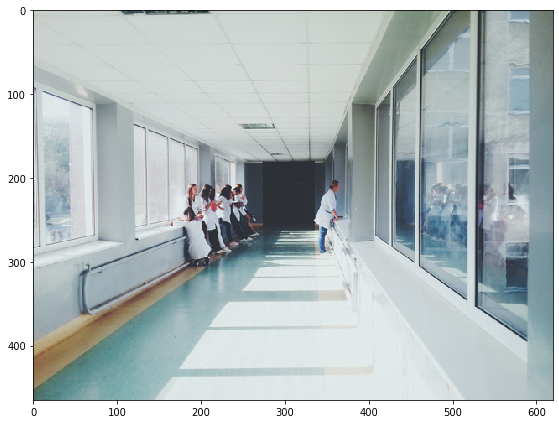

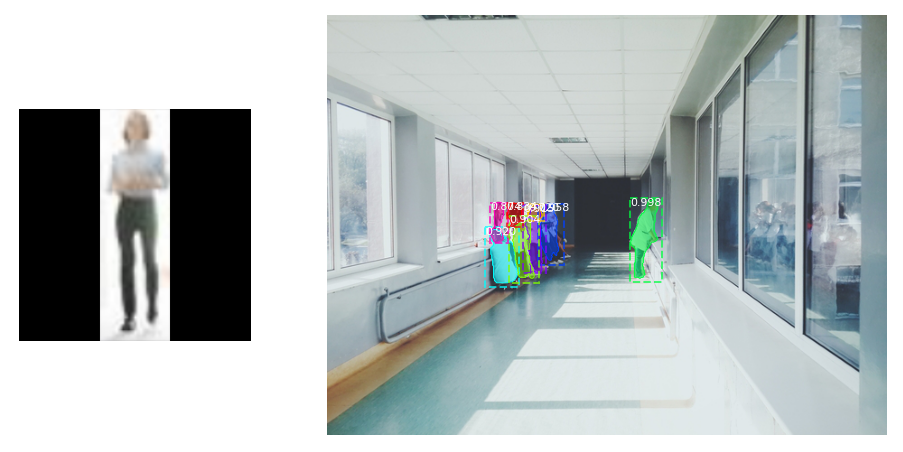

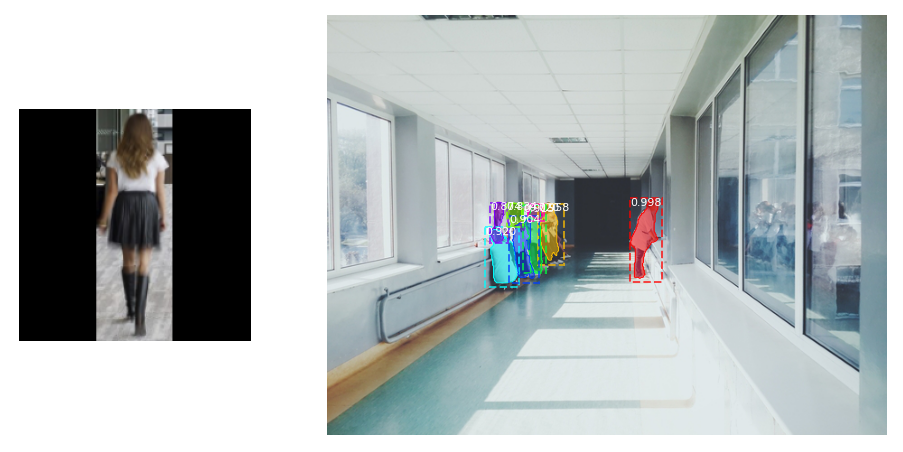

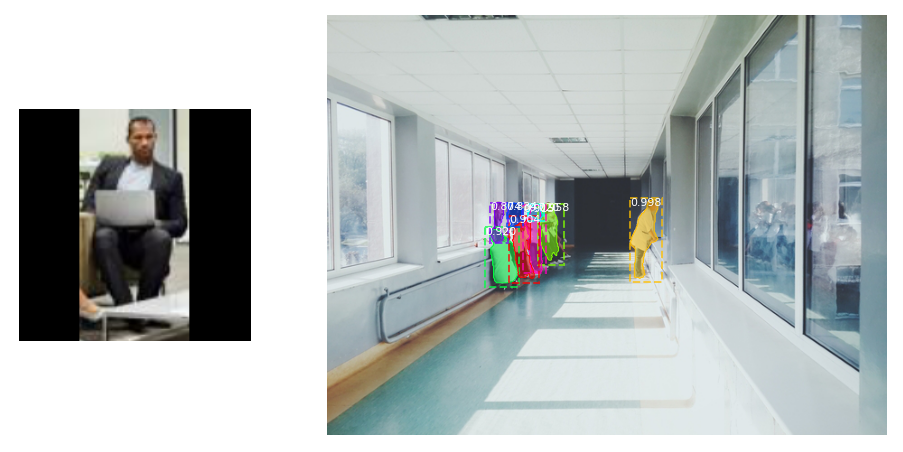

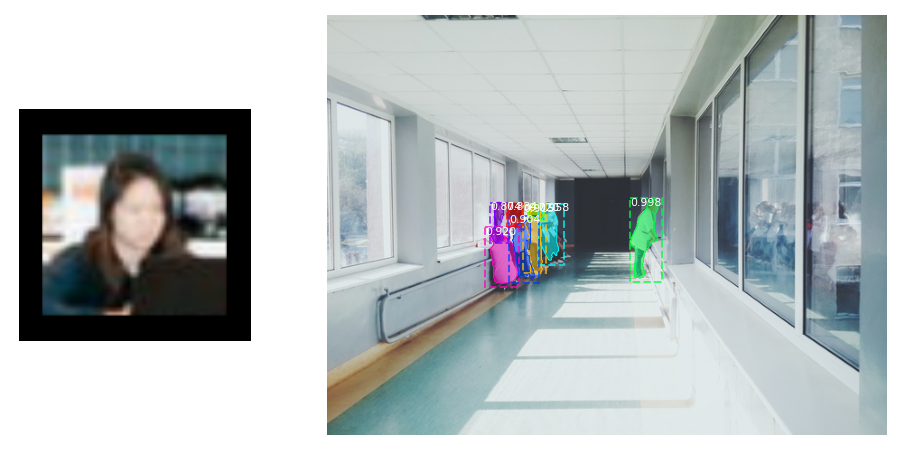

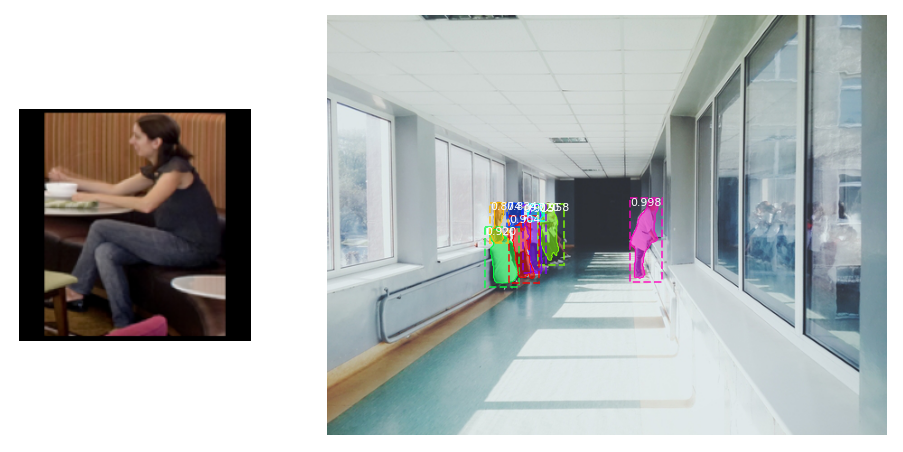

In [13]:
from skimage import io
# Select category
# classes = person, chair, couch, door, desk, elevator
#              1      2      3     4     5       6
category = 1
image_id = np.random.choice(queryset.category_image_index[category])   

# Load reference images
ref_images = []
for i in range(config.NUM_TARGETS):
    ref_image = siamese_utils.get_one_target(category, queryset, config)
    ref_images.append(ref_image)

# Load query image from test set
query_image = queryset.load_image(image_id)
print("image_id", image_id)

# Load logitech c270 cam image
query_image1 = io.imread("/content/drive/My Drive/Thesis/siamese-mask-rcnn/data/logitech-c270/cam_01.jpg")
query_image2 = io.imread("/content/drive/My Drive/Thesis/siamese-mask-rcnn/data/logitech-c270/cam_04.jpg")
query_image3 = io.imread("/content/drive/My Drive/Thesis/siamese-mask-rcnn/data/logitech-c270/cam_07.jpg")
query_image4 = io.imread("/content/drive/My Drive/Thesis/siamese-mask-rcnn/data/logitech-c270/cam_11.jpg")
query_image5 = io.imread("/content/drive/My Drive/Thesis/siamese-mask-rcnn/data/logitech-c270/cam_14.jpg")
query_image6 = io.imread("/content/drive/My Drive/Thesis/siamese-mask-rcnn/data/logitech-c270/cam_16.jpg")
query_images = [query_image1, query_image2, query_image3, query_image4, query_image5]
# print("camera image")

# Run detection
results = model.detect_category(category=category, targets=[ref_images], images=[query_image], verbose=1)
r = results[0]

# Display results
io.imshow(query_image)
io.show()
for j in range(config.NUM_TARGETS):
    siamese_utils.display_results(ref_images[j], query_image, r['rois'], r['masks'], r['class_ids'], r['scores'])